In [1]:
%load_ext autoreload
%autoreload 2

# Vanilla MCDropout

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from collections import OrderedDict
from torch.utils.data import TensorDataset, DataLoader

In [6]:

device = torch.device("cpu")
dim = 1
def oracle(x, noise=0):
    # returns sin(2pi x) + epsilon with epsilon ~ N(0, 0.1)
    with torch.no_grad():
        m = torch.distributions.Normal(torch.tensor([0.0]), torch.tensor([1]))
        m = m.sample((x.size(0),))
    return torch.where(torch.logical_and(x > 0.5, x < 1.5),
                       3./5 * (torch.sin(x) * torch.cos(5 * x) * torch.cos(22 * x) * -3 * torch.sin(7 * x) * torch.cos(19 * x) * 4 * torch.sin(11 * x)),
                       (2 * np.pi * x).sin()) + noise * m

def generate_data(n=1024, nood=32):
    # generate data from U([0, 1/2] union U([1/2 + sep, 1 + sep]))
    # sep needs to be < 1.5
    with torch.no_grad():
        x = torch.zeros(n // 2, 1).uniform_(0, 0.5)
        x = torch.cat((x, torch.zeros(n // 2, 1).uniform_(1.5, 2)), 0)
        ood_x = torch.zeros(32, 1).uniform_(0.5, 1.5) # it's not really ood x, but just the x s that are in the spiked regions
        x_test = torch.linspace(-0.5, 2.5, 1024).view(-1, 1)
        ood_x = torch.zeros(nood // 4, 1).uniform_(-0.25, 0.0)
        ood_x = torch.cat((ood_x, torch.zeros(nood // 4, 1).uniform_(2, 2.25)), 0)
        ood_x = torch.cat((ood_x, torch.zeros(nood, 1).uniform_(0.5, 1.5)), 0)
        y = oracle(x)
        ood_y = oracle(ood_x)
        y_test_true = oracle(x_test, noise=0)
        return x, y, x_test, y_test_true, ood_x, ood_y

x, y, x_test, y_test, ood_x, ood_y = generate_data(1024, 24)

# ood_x = cheat_remove(ood_x, (0.65, 0.7))
ood_y = oracle(ood_x)
X_train = torch.cat((x, ood_x))
Y_train = torch.cat((y, ood_y))

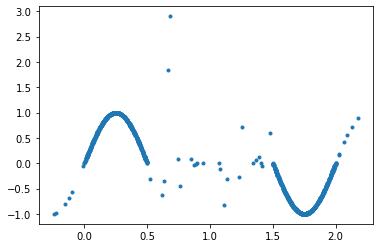

In [7]:
plt.plot(X_train, Y_train.squeeze(), '.')

In [8]:
input_dim = 1
output_dim = 1
activation_fn = nn.ReLU
loss_fn = nn.MSELoss()

In [9]:
def make_model_and_optim(lr, dropout_prob, n_hidden=32, hidden_layers=1):
    model = nn.Sequential(OrderedDict([
        ('input_layer', nn.Linear(input_dim, n_hidden)),
        ('activation1', activation_fn()),
        ('dropout1', nn.Dropout(p=dropout_prob)),
    ]))
    for i in range(hidden_layers):
        model.add_module('hidden_layer{}'.format(i + 1), nn.Linear(n_hidden, n_hidden))
        model.add_module('activation{}'.format(i + 2), activation_fn())
        model.add_module('dropout{}'.format(i + 2), nn.Dropout(p=dropout_prob))
    model.add_module('output_layer', nn.Linear(n_hidden, output_dim))
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    return model, optimizer

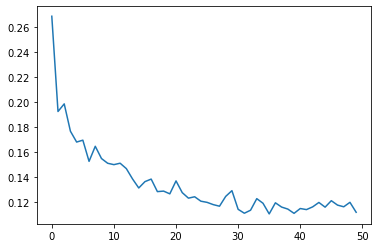

In [26]:
epochs = 50
lr = 1e-2
batch_size = 32
model, optimizer = make_model_and_optim(lr=lr, dropout_prob=0.4, hidden_layers=1)
model.train()
data = TensorDataset(X_train, Y_train)

loader = DataLoader(data, shuffle=True, batch_size=batch_size)
losses = []
for epoch in range(epochs):
    epoch_losses = []
    for batch_id, (xi, yi) in enumerate(loader):
        optimizer.zero_grad()
        y_hat = model(xi)
        f_loss = loss_fn(y_hat, yi)
        epoch_losses.append(f_loss.item())
        f_loss.backward()
        optimizer.step()
    losses.append(np.mean(epoch_losses))
plt.plot(losses)

In [27]:
# Uncertainties
def get_dist(model, x, num_samples=10):
    model.train()
    outputs = torch.cat([model(x).unsqueeze(0) for _ in range(num_samples)])
    y_mean = outputs.mean(0)
    y_std = outputs.std(0)
    return y_mean.detach().squeeze(), y_std.detach().squeeze()

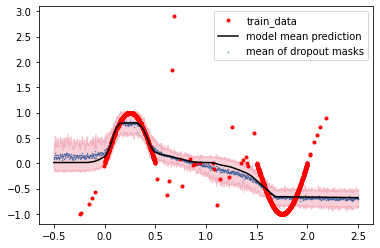

In [28]:
model.eval()
non_dropout_pred = model(x_test).detach()
Y_mean, Y_std = get_dist(model, x_test, num_samples=100)
plt.plot(X_train, Y_train, 'r.', label='train_data')
plt.scatter(x_test, Y_mean, s=.2, label='mean of dropout masks')

plt.plot(x_test, non_dropout_pred, 'k', label='model mean prediction')

plt.fill_between(x_test.squeeze(), Y_mean - Y_std, Y_mean + Y_std, color='crimson', alpha=.2)
plt.legend()

# Model with custom dropout mask


In [31]:
from masks import DifferentiableBernoulli, ModelWithDropout

In [32]:
model_drop = ModelWithDropout().to(torch.double)

None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None


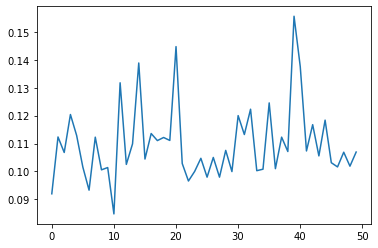

In [37]:
# match in-sample L2 errors (not really DEUP)
lr = 1e-4
epochs=50
optimizer = torch.optim.Adam(model_drop.parameters(), lr=lr)
loader = DataLoader(data, shuffle=True, batch_size=batch_size)
losses = []
for epoch in range(epochs):
    
    epoch_losses = []
    for batch_id, (xi, yi) in enumerate(loader):
        optimizer.zero_grad()
        model_drop.train()
        y_mean = model(xi)
        model_drop.eval()
        y_noisy = model(xi)
        pred_uncertainty = (y_mean - y_noisy) ** 2
        true_uncertainty = (yi - y_mean) ** 2
        f_loss = loss_fn(pred_uncertainty, true_uncertainty)
        epoch_losses.append(f_loss.item())
        f_loss.backward()
        print(model_drop.premask.grad)
        optimizer.step()
    losses.append(np.mean(epoch_losses))
plt.plot(losses)